<a href="https://colab.research.google.com/github/Patric-Ramz/Patric-Ramz/blob/main/Pop_Density/Columbia_population_density.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Columbia Population Density**

The following code is to increase the granularity of population density estimates based on geospatial data.

I will be using light pollution as a predictor for population density.



In [3]:
install.packages(c("fst", "tidyverse", "dplyr", "corrplot", "Hmisc", "stats", "purrr", "randomForest", "caret", "Metrics", "gridExtra"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘stats’ is a base package, and should not be updated”
also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘checkmate’, ‘htmlwidgets’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘fstcore’, ‘Rcpp’, ‘htmlTable’, ‘viridis’, ‘Formula’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’




In [5]:
library(fst)
library(tidyverse)
library(dplyr)
library(corrplot)
library(Hmisc)
library(stats)
library(purrr)
library(randomForest)
library(caret)
library(Metrics)
library(gridExtra)
library(googledrive)


drive_auth()

Is it OK to cache OAuth access credentials in the folder ~/.cache/gargle
between R sessions?
1: Yes
2: No


Selection: 1


Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=f8ab743c458b1ac5f1e903bdb7b0363d&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQWVhWVNIRHk4RWpnVGJQMlBEM091Xzc5UWROaHY3OHF0SEhuTEpReFFFWlQ0NTU2OUxfZThRTmlPQnY2a3JxeDV4SzR6QSIsInN0YXRlIjoiZjhhYjc0M2M0NThiMWFjNWYxZTkwM2JkYjdiMDM2M2QifQ==


`geom_smooth()` using formula = 'y ~ x'


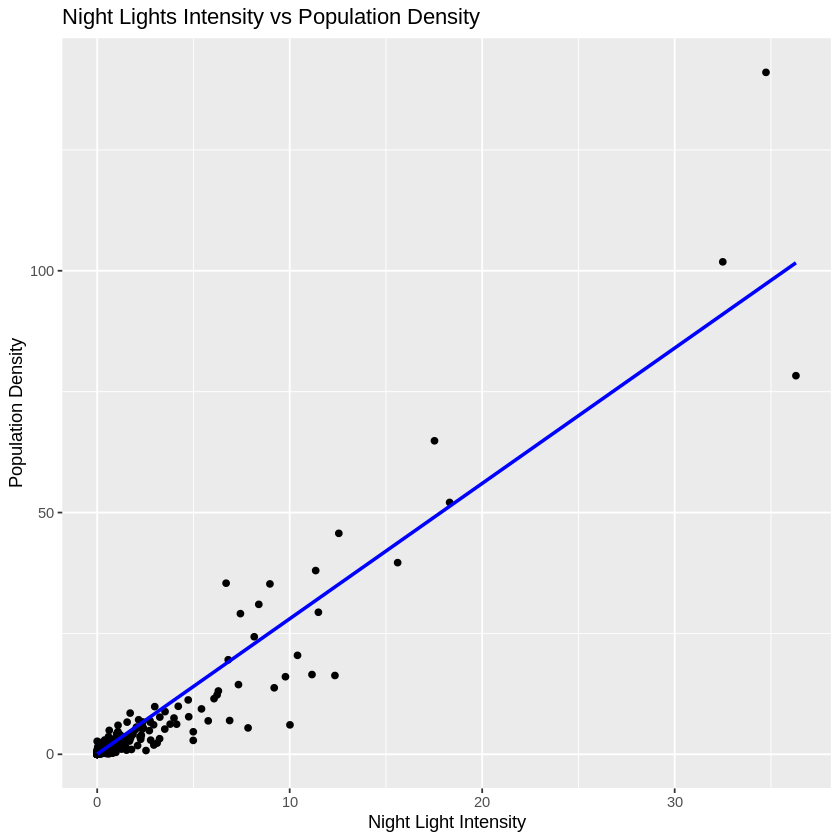

In [6]:
muni_level_data <- read_fst('colombia_input.fst')
quindio_data <- read_fst('quindio_input_grid.fst')

ggplot(muni_level_data, aes(x = night_lights_100, y = raster_pop_100)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE, color = "blue") +
  labs(x = "Night Light Intensity", y = "Population Density") +
  ggtitle("Night Lights Intensity vs Population Density")

In [7]:
# Removing columns with no information
muni_level_data <- muni_level_data %>% select(-globcover_cls100, -globcover_cls60, -raster_geocode_100)

# Calculate Q1, Q3, and IQR
Q1 <- quantile(muni_level_data$raster_pop_100, 0.25)
Q3 <- quantile(muni_level_data$raster_pop_100, 0.75)
IQR <- Q3 - Q1

# Define lower bound and upper bound
lower_bound <- Q1 - 5 * IQR
upper_bound <- Q3 + 5 * IQR

# Identify the outliers
outliers <- muni_level_data$raster_pop_100[muni_level_data$raster_pop_100 < lower_bound | muni_level_data$raster_pop_100 > upper_bound]

# Removing outliers
muni_level_data <- muni_level_data[!(muni_level_data$raster_pop_100 < lower_bound | muni_level_data$raster_pop_100 > upper_bound), ]

# Prepare the training and testing datasets
set.seed(42)  # Set a seed for reproducibility
train_indices <- sample(nrow(muni_level_data), nrow(muni_level_data) * 0.7)  # 70% for training

train_set <- muni_level_data[train_indices, ]  # Training set
test_set <- muni_level_data[-train_indices, ]  # Test set

# Train the model with 200 ntree value
model <- randomForest(x = train_set[-ncol(train_set)],
                      y = train_set$raster_pop_100,
                      ntree = 200)

# Predict on the test set
y_pred <- predict(model, newdata = test_set[-ncol(test_set)])

# Calculate the evaluation metrics
mse <- mse(test_set$raster_pop_100, y_pred)
rmse <- sqrt(mse)
mae <- mae(test_set$raster_pop_100, y_pred)
R2 <- postResample(pred = y_pred, obs = test_set$raster_pop_100)[["Rsquared"]]
Adj_R2 <- 1 - ((1 - R2) * ((nrow(test_set) - 1) / (nrow(test_set) - ncol(test_set) - 1)))

# Print the metrics
print(paste("Mean Squared Error (MSE):", mse))
print(paste("Root Mean Squared Error (RMSE):", rmse))
print(paste("Mean Absolute Error (MAE):", mae))
print(paste("R-squared:", round(R2, 3)))
print(paste("Adjusted R-squared:", round(Adj_R2, 3)))

[1] "Mean Squared Error (MSE): 0.00918403619210997"
[1] "Root Mean Squared Error (RMSE): 0.0958333772341869"
[1] "Mean Absolute Error (MAE): 0.050311700728872"
[1] "R-squared: 0.983"
[1] "Adjusted R-squared: 0.978"


In [9]:
#reload muni_level_data
muni_level_data <- read_fst('colombia_input.fst')

# Make the prediction
quindio_data$predicted_pop_density <- predict(model, newdata = quindio_data)

# Calculate the sum of the official and predicted values for each municipality
official_sums <- aggregate(raster_pop_100 ~ raster_geocode_100, muni_level_data, sum)
predicted_sums <- aggregate(predicted_pop_density ~ raster_geocode_100, quindio_data, sum)

# Merge the two data frames so that we can calculate the adjustment factor for each municipality
sums <- merge(official_sums, predicted_sums, by = "raster_geocode_100")

# Calculate the adjustment factor
sums$adjustment_factor <- sums$raster_pop_100 / sums$predicted_pop_density

# Apply the adjustment factor to the grid-level predictions
quindio_data$adjusted_predicted_pop_density <- quindio_data$predicted_pop_density * sums$adjustment_factor

Warning message in quindio_data$predicted_pop_density * sums$adjustment_factor:
“longer object length is not a multiple of shorter object length”


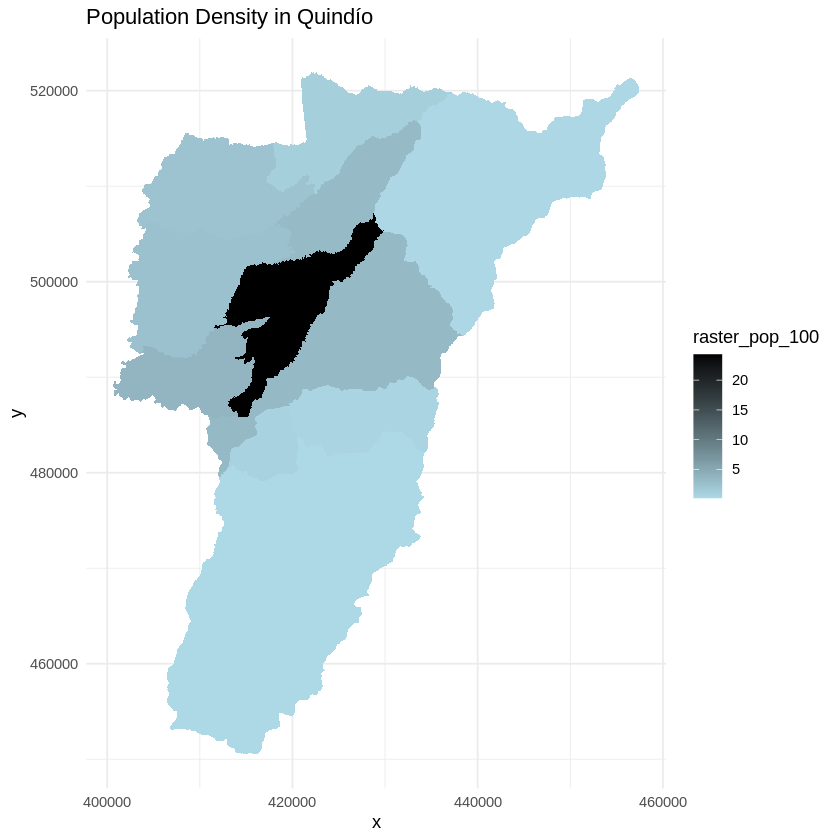

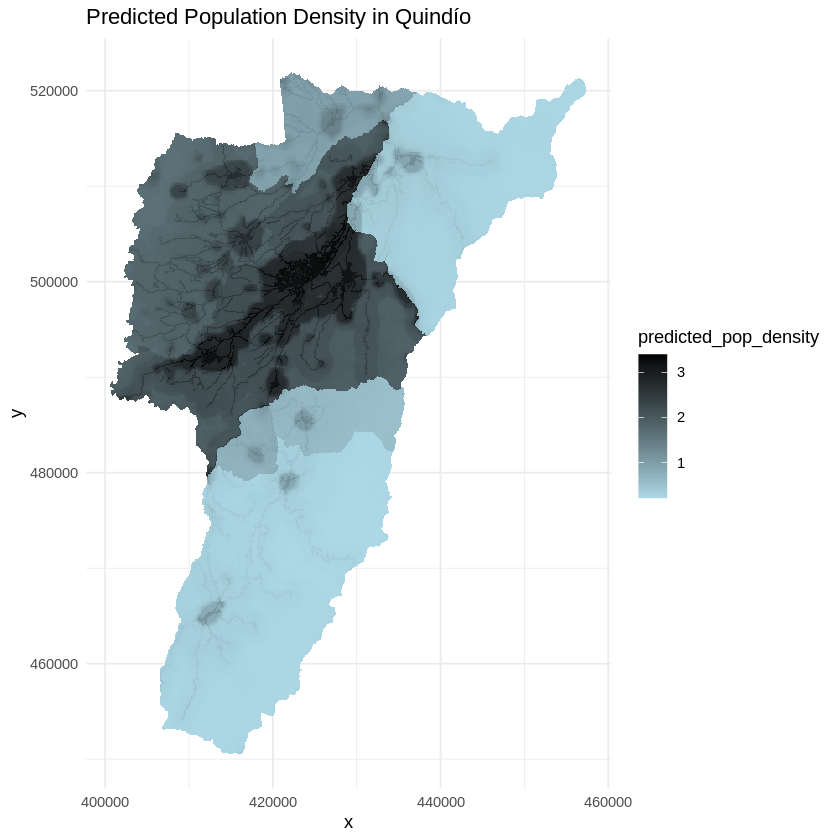

In [10]:
# Create the base plot
base <- ggplot(data = quindio_data, aes(x = x, y = y)) +
  theme_minimal()

# Plot the original data
input_plot <- base +
  geom_tile(aes(fill = raster_pop_100)) +
  scale_fill_gradient(low = "lightblue", high = "black") +
  ggtitle("Population Density in Quindío")
input_plot

# Plot the predicted data
prediction_plot <- base +
  geom_tile(aes(fill = predicted_pop_density)) +
  scale_fill_gradient(low = "lightblue", high = "black") +
  ggtitle("Predicted Population Density in Quindío")
prediction_plot